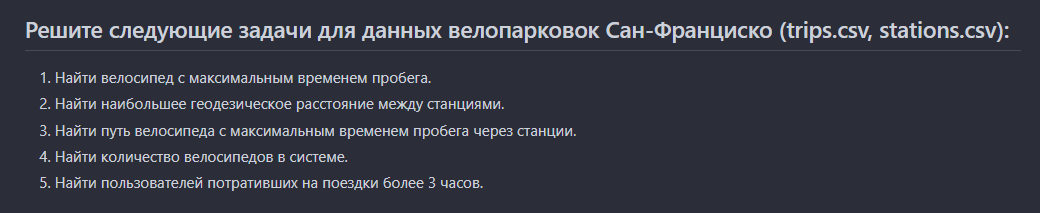

In [ ]:
!python3 -m venv venv
!source venv/bin/activate 
!python3 -m pip install numpy

In [ ]:
!python --version

In [432]:
from pyspark import SparkContext, SparkConf 
conf = SparkConf().setAppName("laba 1 Gorelykh").setMaster('yarn')

In [433]:
sc = SparkContext.getOrCreate(conf = conf)

In [434]:
tripData = sc.textFile("big_data/data/trips.csv")

tripsHeader = tripData.first()
trips = tripData.filter(lambda row: row != tripsHeader).map(lambda row: row.split(",", -1))

1. Найти велосипед с максимальным временем пробега.

In [435]:
trips.count()

669959

In [436]:
trips.take(2)

[['4576',
  '63',
  '',
  'South Van Ness at Market',
  '66',
  '8/29/2013 14:14',
  'South Van Ness at Market',
  '66',
  '520',
  'Subscriber',
  '94127'],
 ['4607',
  '',
  '8/29/2013 14:42',
  'San Jose City Hall',
  '10',
  '8/29/2013 14:43',
  'San Jose City Hall',
  '10',
  '661',
  'Subscriber',
  '95138']]

In [437]:
from typing import NamedTuple
from datetime import datetime

def initTrip(trips):
    class Trip(NamedTuple):
        trip_id: int
        duration: int
        start_date: datetime
        start_station_name: str
        start_station_id: int
        end_date: datetime
        end_station_name: str
        end_station_id: int
        bike_id: int
        subscription_type: str
        zip_code: str
        
    for trip in trips:
        try:
            yield Trip(                             
             trip_id = int(trip[0]),
             duration = int(trip[1]),
             start_date = datetime.strptime(trip[2], '%m/%d/%Y %H:%M'),
             start_station_name = trip[3],
             start_station_id = int(trip[4]),
             end_date = datetime.strptime(trip[5], '%m/%d/%Y %H:%M'),
             end_station_name = trip[6],
             end_station_id = trip[7],
             bike_id = int(trip[8]),
             subscription_type = trip[9],
             zip_code = trip[10]
            ) 
        except:
            pass

In [438]:
tripsInternal = trips.mapPartitions(initTrip)

In [439]:
trips_by_bike_id = tripsInternal.keyBy(lambda trip: trip.bike_id)
trips_by_bike_id.take(1)

[(48,
  Trip(trip_id=4130, duration=71, start_date=datetime.datetime(2013, 8, 29, 10, 16), start_station_name='Mountain View City Hall', start_station_id=27, end_date=datetime.datetime(2013, 8, 29, 10, 17), end_station_name='Mountain View City Hall', end_station_id='27', bike_id=48, subscription_type='Subscriber', zip_code='97214'))]

In [440]:
trips_by_duration = trips_by_bike_id.mapValues(lambda trip: trip.duration)

In [441]:
trips_by_duration.groupByKey().mapValues(sum).top(1,  key=lambda x: x[1])

[(535, 18611693)]

In [442]:
t = trips_by_duration.groupByKey().mapValues(sum)

In [443]:
%%time
m = t.map(lambda x: x).top(1, key=lambda x: x[1])

CPU times: user 11 ms, sys: 5.47 ms, total: 16.4 ms
Wall time: 17 s


In [444]:
print(f"Id: {m[0][0]}, max of duration: {int(m[0][1])/60} min")

Id: 535, max of duration: 310194.88333333336 min


2. Найти наибольшее геодезическое расстояние между станциями.

In [445]:
def initStation(stations):
    class Station(NamedTuple):
        station_id: int
        name: str
        lat: float
        long: float
        dockcount: int
        landmark: str
        installation: str
    
    for station in stations:
        yield Station(
            station_id = int(station[0]),
            name = station[1],
            lat = float(station[2]),
            long = float(station[3]),
            dockcount = int(station[4]),
            landmark = station[5],
            installation = datetime.strptime(station[6], '%m/%d/%Y')
        )

In [446]:
station_data = sc.textFile("big_data/data/stations.csv")

stationsHeader = station_data.first()
stations = station_data.filter(lambda row: row != stationsHeader).map(lambda row: row.split(",", -1))

In [447]:
stationsInternal = stations.mapPartitions(initStation)

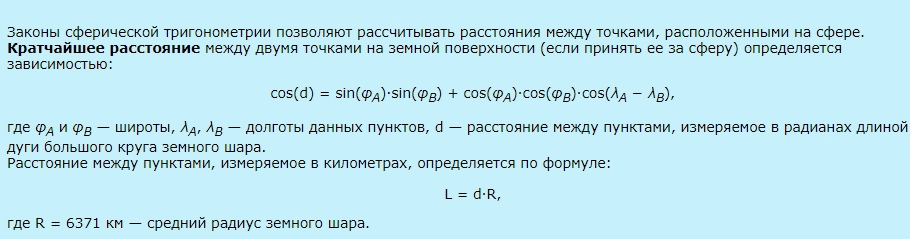

In [448]:
stationsInternal.cartesian(stationsInternal).map(lambda el: (math.sin(math.radians(el[0].lat))*math.sin(math.radians(el[1].lat)) + math.cos(math.radians(el[0].lat))*math.cos(math.radians(el[1].lat))*math.cos(math.radians(el[0].long) - math.radians(el[1].long)))).map(lambda v: np.arccos(v)*6371).max()

69.92087595421542

3. Найти путь велосипеда с максимальным временем пробега через станции.

In [449]:
id = m[0][0]
print("Велосипед с максимальным временем пробега: ", id)

Велосипед с максимальным временем пробега:  535


In [518]:
trips = tripsInternal.filter(lambda x: x.bike_id == id).map(lambda st: (st.start_station_name, st.end_station_name)).toDF()
trips.show()

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|San Francisco Cal...|San Francisco Cal...|
|     Post at Kearney|San Francisco Cal...|
|   Market at Sansome|   2nd at South Park|
|San Francisco Cal...|   Market at Sansome|
|     2nd at Townsend|    Davis at Jackson|
|San Francisco Cit...|Civic Center BART...|
|Civic Center BART...|     Post at Kearney|
|     Post at Kearney|Embarcadero at Sa...|
|Embarcadero at Sa...|Washington at Kea...|
|Washington at Kea...|   Market at Sansome|
|   Market at Sansome|   Market at Sansome|
|   Market at Sansome|       2nd at Folsom|
|       2nd at Folsom|     2nd at Townsend|
|Temporary Transba...|     2nd at Townsend|
|     2nd at Townsend|Embarcadero at Sa...|
|Embarcadero at Sa...|     Clay at Battery|
|     Clay at Battery|Harry Bridges Pla...|
|Harry Bridges Pla...|     Clay at Battery|
|     Clay at Battery|San Francisco Cal...|
|San Francisco Cal...|   Steuart

In [519]:
trips.count()

1328

In [520]:
from pyspark.sql import SparkSession
m = SparkSession(sc)

In [532]:
from pyspark.sql import Row

paths = (stationsInternal.cartesian(stationsInternal).map(
    lambda el: (el[0].name, el[1].name,
                (math.sin(math.radians(el[0].lat))*math.sin(math.radians(el[1].lat)) + math.cos(math.radians(el[0].lat))*math.cos(math.radians(el[1].lat))*math.cos(math.radians(el[0].long) - math.radians(el[1].long))))
).map(lambda r: (r[0], r[1], float(np.arccos(r[2])*6371)))).map(lambda l: Row(start = l[0], end = l[1], path = l[2])).distinct().toDF()

In [533]:
a = trips.join(paths, [paths.start == trips._1, paths.end == trips._2]).select(paths.path).dropna()

In [534]:
a.summary().show()

+-------+------------------+
|summary|              path|
+-------+------------------+
|  count|              1290|
|   mean|1.3223530301812394|
| stddev|0.6515968231492477|
|    min|               0.0|
|    25%|0.8862659414511413|
|    50%|1.3103447989707473|
|    75%|1.6968400376984512|
|    max| 3.748878664203335|
+-------+------------------+



In [535]:
print("Путь в киллометрах: ")
a.groupby().sum().show()

Путь в киллометрах: 
+------------------+
|         sum(path)|
+------------------+
|1705.8354089337986|
+------------------+



4. Найти количество велосипедов в системе.

In [463]:
bikes = tripsInternal.map(lambda row: row.bike_id).distinct()

In [464]:
bikes.count()

700

5. Найти пользователей потративших на поездки более 3 часов.

In [515]:
trips_by_trip_id = tripsInternal.keyBy(lambda trip: trip.trip_id)

In [516]:
trips_by_duration_more_3_hours = trips_by_trip_id.mapValues(lambda trip: trip.duration).filter(lambda trip: trip[1] > 3*60*60)

In [517]:
trips_by_duration_more_3_hours.collect()

[(4639, 11118),
 (4637, 11272),
 (4528, 12280),
 (4363, 15244),
 (4193, 18192),
 (4190, 18240),
 (4225, 21612),
 (4663, 52698),
 (4532, 84990),
 (4521, 85385),
 (5069, 86102),
 (4505, 97713),
 (5539, 10805),
 (6032, 10963),
 (6409, 12408),
 (6408, 12459),
 (5697, 12562),
 (5683, 12875),
 (5218, 13809),
 (5716, 14545),
 (5717, 14568),
 (5241, 15160),
 (5537, 16570),
 (5253, 16713),
 (5531, 16744),
 (6131, 16933),
 (6098, 17593),
 (6091, 17774),
 (5115, 18198),
 (5114, 18206),
 (5250, 18219),
 (5249, 18241),
 (5508, 20920),
 (5506, 20931),
 (5167, 23182),
 (5166, 23212),
 (5640, 23319),
 (5638, 23360),
 (6003, 23694),
 (5380, 25335),
 (5222, 27103),
 (5120, 33088),
 (5113, 34449),
 (5182, 36255),
 (6412, 70731),
 (6178, 70982),
 (6462, 77919),
 (5493, 83224),
 (6282, 241334),
 (7069, 11161),
 (6626, 11632),
 (6963, 11642),
 (7074, 11653),
 (6962, 11675),
 (7067, 11825),
 (6792, 11964),
 (7143, 12303),
 (6613, 12400),
 (7176, 12818),
 (7081, 14180),
 (7079, 14299),
 (7021, 14451),
 (7016,